In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import os
import time
from scipy import stats
from scipy import constants
from scipy.integrate import odeint
from scipy.optimize import curve_fit



from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import  MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.12.1+cpu


In [35]:
# trainning and validation data
data_h_lhs=pd.read_csv('h_LHS.csv',index_col=False)
data_lambda_lhs=pd.read_csv('lambda_LHS.csv',index_col=False)
data_T_lhs=pd.read_csv('T_LHS.csv',index_col=False)
data_strain_lhs=pd.read_csv('strain_LHS.csv')



##testing data
data_h_uniform_5000=pd.read_csv('h_uniform_5000.csv',index_col=False)
data_T_uniform_5000=pd.read_csv('T_uniform_5000.csv',index_col=False)
data_lambda_uniform_5000=pd.read_csv('lambda_uniform_5000.csv',index_col=False)
data_strain_uniform_5000=pd.read_csv('strain_uniform_5000.csv')


data_h_lhs=data_h_lhs.append (data_h_uniform_5000[0:100])
data_lambda_lhs=data_lambda_lhs.append(data_lambda_uniform_5000[0:100])
data_T_lhs=data_T_lhs.append(data_T_uniform_5000[0:100])
data_strain_lhs=data_strain_lhs.append(data_strain_uniform_5000[0:100])



C:\Users\rahma\AppData\Local\Temp\ipykernel_8336\3691299296.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_h_lhs=data_h_lhs.append (data_h_uniform_5000[0:100])
C:\Users\rahma\AppData\Local\Temp\ipykernel_8336\3691299296.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_lambda_lhs=data_lambda_lhs.append(data_lambda_uniform_5000[0:100])
C:\Users\rahma\AppData\Local\Temp\ipykernel_8336\3691299296.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_T_lhs=data_T_lhs.append(data_T_uniform_5000[0:100])
C:\Users\rahma\AppData\Local\Temp\ipykernel_8336\3691299296.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_

In [36]:
### Reading values only for trainning data
h_in=data_h_lhs.values
T_in=data_T_lhs.values
Lambda_in=data_lambda_lhs.values
strain_in=data_strain_lhs.values

# converting to tensor
h_in_notscaled=torch.tensor(h_in).float()
T_in_notscaled=torch.tensor(T_in).float()
Lambda_in_notscaled=torch.tensor(Lambda_in).float()
strain_in_notscaled=torch.tensor(strain_in).float()




Lambda_in_test_5000=data_lambda_uniform_5000.values
strain_in_test_5000=data_strain_uniform_5000.values

# Scaling the input and outputs
min_max_scaler_h =MinMaxScaler()
min_max_scaler_T =MinMaxScaler()
min_max_scaler_lambda =MinMaxScaler()
min_max_scaler_strain=MinMaxScaler()

h_scale_in= min_max_scaler_h.fit_transform(h_in)
T_scale_in= min_max_scaler_T.fit_transform(T_in)
Lambda_scale_in= min_max_scaler_lambda.fit_transform(Lambda_in)
strain_scale_in=min_max_scaler_strain.fit_transform(strain_in)

## Converting into tensor for nn only 3000 data taken for trainning with LHS
h_tensor=torch.Tensor(h_scale_in)[2000:5100]
T_tensor=torch.Tensor(T_scale_in)[2000:5100]
Lambda_tensor=torch.Tensor(Lambda_scale_in)[2000:5100]
strain_tensor=torch.Tensor(strain_scale_in)[2000:5100]



# testing data 2000 from LHS
h_tensor_2000=torch.Tensor(h_scale_in)[0:2000]
T_tensor_2000=torch.Tensor(T_scale_in)[0:2000]
Lambda_tensor_2000=torch.Tensor(Lambda_scale_in)[0:2000]
strain_tensor_2000=torch.Tensor(strain_scale_in)[0:2000]


##test Data preparation generated from uniform input sampling
h_test_in_5000=data_h_uniform_5000.values
T_test_in_5000=data_T_uniform_5000.values
lambda_test_in_5000=data_lambda_uniform_5000.values
strain_test_in_5000=data_strain_uniform_5000.values

min_max_scaler_h_5000 =MinMaxScaler()
min_max_scaler_T_5000 =MinMaxScaler()
min_max_scaler_Lambda_5000=MinMaxScaler()
min_max_scaler_strain_5000=MinMaxScaler()

scale_h_test_in_5000=min_max_scaler_h_5000.fit_transform(h_test_in_5000)
scale_T_test_in_5000=min_max_scaler_T_5000.fit_transform(T_test_in_5000)
scale_Lambda_test_in_5000=min_max_scaler_Lambda_5000.fit_transform(lambda_test_in_5000)
scale_strain_test_in_5000=min_max_scaler_strain_5000.fit_transform(strain_test_in_5000)

h_tensor_5000=torch.Tensor(scale_h_test_in_5000)
T_tensor_5000=torch.Tensor(scale_T_test_in_5000)
Lambda_tensor_5000=torch.tensor(scale_Lambda_test_in_5000)
strain_tensor_5000=torch.tensor(scale_strain_test_in_5000)

# test data
h_in_notscaled_5000=torch.tensor(h_test_in_5000).float()
T_in_notscaled_5000=torch.tensor(T_test_in_5000).float()
lambda_in_notscaled_5000=torch.tensor(lambda_test_in_5000).float()
strain_in_notscaled_5000=torch.tensor(strain_test_in_5000).float()

# zipped_tensor=zip(h_tensor,T_tensor,Lambda_tensor)
# tuple = (h_tensor, T_tensor)
# new_tensor = torch.cat(tuple,-1)
# T = torch.stack((h_tensor,T_tensor), -1)  ## this one is working
# new_tensor


# Appending the T=0 data in LHS sampling
# h_tensor_3100=torch.concat((h_tensor,h_tensor_5000[0:100]),0)
# T_tensor_3100=torch.concat((T_tensor,T_tensor_5000[0:100]),0)
# Lambda_tensor_3100=torch.concat((Lambda_tensor,Lambda_tensor_5000[0:100]),0)
# strain_tensor_3100=torch.concat((strain_tensor,strain_tensor_5000[0:100]),0)

In [40]:
# Define the neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)
        self.fc4 = nn.Linear(2, 32)
        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 1)

    def forward(self, h,T):
        
        # tuple_in1 = (h_tensor, T_tensor)
        # in_1 = torch.cat(tuple_in1,-1)
        in_1=torch.concat((h,T),1)  ## Concating the inputs to NN
        # in_1 = torch.stack(h,T)
        # in_1=torch.concat(h,T)
        x1 = torch.relu(self.fc1(in_1))                                           ## First NN
        x2 = torch.relu(self.fc2(x1))
        output_1 = self.fc3(x2)

        # tuple_in2 = (output_1, h_tensor)
        # in_2 = torch.cat(tuple_in2,-1)
        in_2=torch.concat((output_1,h),1)
        # in_2 = torch.stack(output_1,h)
        # in_2=torch.concat(output_1,h)                                         ## second NN
        x3 = torch.relu(self.fc4(in_2))
        x4 = torch.relu(self.fc5(x3))
        output_2 = self.fc6(x4)
        return output_1,output_2

# Create a model instance from the network
model = Net()
print(model)


Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Linear(in_features=2, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
)


In [41]:
loss_criteria=nn.MSELoss()
## Trainning function definition
alpha=1
beta=1
def train(model,h,T,lam,optimizer):
  for i in range(len(h)):
    model.train()
    
    # for i in range(len(h)):
    # optimizer.zero_grad()
    out1,out2=model(h,T)
    loss1=loss_criteria(out1,lam)
    loss2=loss_criteria(out2,T)
    loss=alpha*loss1+beta*loss2
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss,out1,out2

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 10
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss,lambda_out,T_out = train(model,h_tensor,T_tensor,Lambda_tensor , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    print(np.sqrt(train_loss.detach().numpy()))
    # validation_loss.append(test_loss)

Epoch: 1
0.07159236
Epoch: 2
0.09044246
Epoch: 3
0.052614108
Epoch: 4
0.06256565
Epoch: 5
0.05087418
Epoch: 6
0.050541483
Epoch: 7
0.061250385
Epoch: 8
0.05002963
Epoch: 9
0.049848456
Epoch: 10
0.05064495


<function matplotlib.pyplot.show(close=None, block=None)>

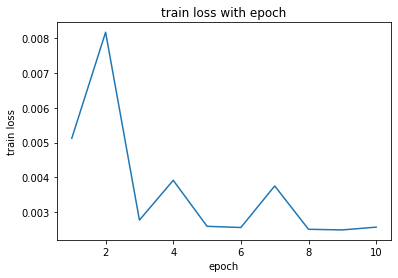

In [43]:
tensor_trainning_loss = torch.tensor(training_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title('train loss with epoch')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

In [64]:
prediction_3000=model(h_tensor,T_tensor)
# predicton for the train data


<function matplotlib.pyplot.show(close=None, block=None)>

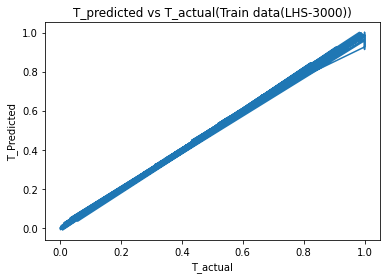

In [65]:
plt.plot(T_tensor,prediction_3000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Train data(LHS-3000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for trainning data

In [46]:
prediction_2000=model(h_tensor_2000,T_tensor_2000)
## prediction for the remaining 2000 samples of LHS

<function matplotlib.pyplot.show(close=None, block=None)>

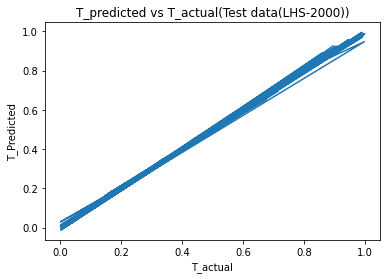

In [47]:
plt.plot(T_tensor_2000,prediction_2000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test data(LHS-2000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for 2000 samples of LHS

<function matplotlib.pyplot.show(close=None, block=None)>

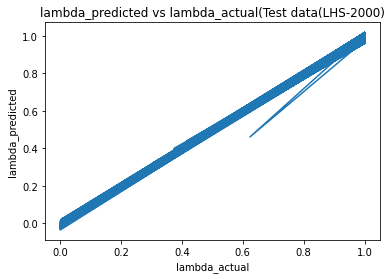

In [48]:
plt.plot(Lambda_tensor_2000,prediction_2000[0].detach().numpy())
plt.xlabel("lambda_actual")
plt.ylabel("lambda_predicted")
plt.title('lambda_predicted vs lambda_actual(Test data(LHS-2000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for 2000 samples of LHS

In [49]:
prediction_5000=model(h_tensor_5000,T_tensor_5000)
## predoction fpr the data test data generated from uniform input sampling

<function matplotlib.pyplot.show(close=None, block=None)>

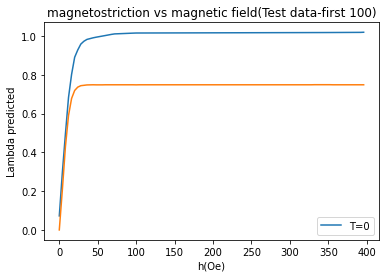

In [50]:
plt.plot(h_test_in_5000[0:100]/79.77,prediction_5000[0][0:100].detach().numpy())
plt.plot(h_test_in_5000[0:100]/79.77,(Lambda_tensor_5000[0:100]))
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted")
plt.legend(['T=0'])
plt.title('magnetostriction vs magnetic field(Test data-first 100)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot for uniform samples and fixed T 

In [51]:
predicted_uni=min_max_scaler_Lambda_5000.inverse_transform(prediction_5000[0].detach().numpy())*10**6
actual_uni=min_max_scaler_Lambda_5000.inverse_transform(Lambda_tensor_5000)*10**6

<function matplotlib.pyplot.show(close=None, block=None)>

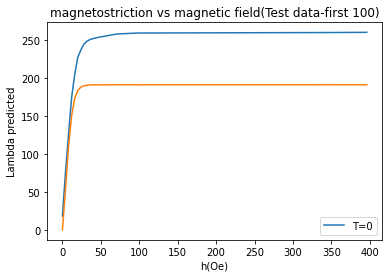

In [56]:
# plt.plot(h_test_in_5000[0:100]/79.77,predicted_uni[0:100])
# plt.plot(h_test_in_5000[0:100]/79.77,actual_uni[0:100])
plt.plot(h_test_in_5000[0:100]/79.77,predicted_uni[0:100])
plt.plot(h_test_in_5000[0:100]/79.77,actual_uni[0:100])
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted")
plt.legend(['T=0'])
plt.title('magnetostriction vs magnetic field(Test data-first 100)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot for uniform samples and fixed T

<function matplotlib.pyplot.show(close=None, block=None)>

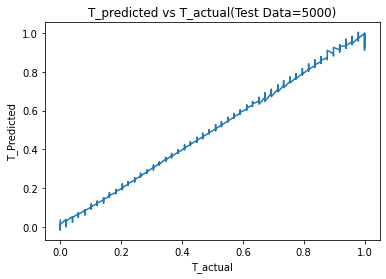

In [53]:
plt.plot(T_tensor_5000,prediction_5000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test Data=5000)')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for uniform input sampling

<function matplotlib.pyplot.show(close=None, block=None)>

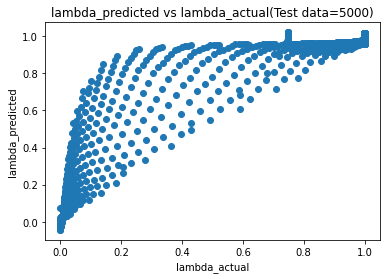

In [54]:
plt.scatter(Lambda_tensor_5000,prediction_5000[0].detach().numpy())
plt.xlabel("lambda_actual")
plt.ylabel("lambda_predicted")
plt.title('lambda_predicted vs lambda_actual(Test data=5000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for uniform samples 

In [55]:
##Saving the model state of 50 epoch

# Additional information
EPOCH = 50
PATH = "model_well.pt"
LOSS = 0.015409946

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [19]:
##Loading model with 100 epoch

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Linear(in_features=2, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
)

In [61]:
# Trainning on strain

model_strain=Net()

In [128]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model_strain.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 10
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss,lambda_out,T_out = train(model_strain,h_tensor,T_tensor,strain_tensor , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    print(np.sqrt(train_loss.detach().numpy()))
    # validation_loss.append(test_loss)

Epoch: 1
0.0113197705
Epoch: 2
0.0023991042
Epoch: 3
0.0046441928
Epoch: 4
0.0015734531
Epoch: 5
0.0014750084
Epoch: 6
0.0014126124
Epoch: 7
0.0013838521
Epoch: 8
0.0013362096
Epoch: 9
0.0013015049
Epoch: 10
0.0028003512


<function matplotlib.pyplot.show(close=None, block=None)>

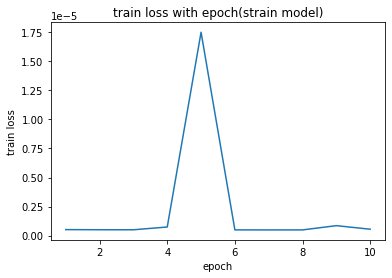

In [110]:
tensor_trainning_loss = torch.tensor(training_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title('train loss with epoch(strain model)')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

In [111]:
prediction_3000=model(h_tensor,T_tensor)
# predicton for the train data

<function matplotlib.pyplot.show(close=None, block=None)>

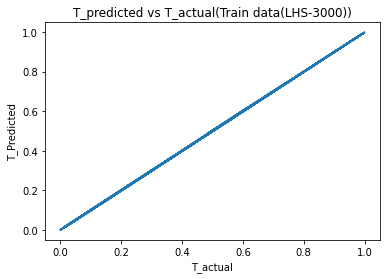

In [112]:
plt.plot(T_tensor,prediction_3000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Train data(LHS-3000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for trainning data

In [113]:
prediction_2000=model(h_tensor_2000,T_tensor_2000)
## prediction for the remaining 2000 samples of LHS

<function matplotlib.pyplot.show(close=None, block=None)>

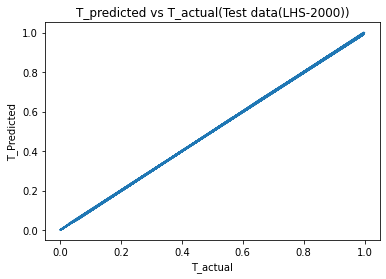

In [114]:
plt.plot(T_tensor_2000,prediction_2000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test data(LHS-2000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for 2000 samples of LHS

<function matplotlib.pyplot.show(close=None, block=None)>

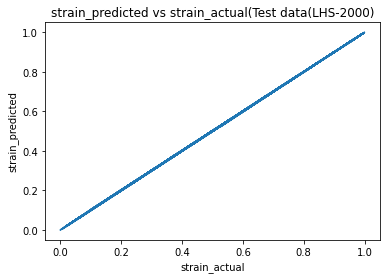

In [115]:
plt.plot(strain_tensor_2000,prediction_2000[0].detach().numpy())
plt.xlabel("strain_actual")
plt.ylabel("strain_predicted")
plt.title('strain_predicted vs strain_actual(Test data(LHS-2000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for 2000 samples of LHS

In [116]:
prediction_5000=model(h_tensor_5000,T_tensor_5000)
## predoction fpr the data test data generated from uniform input sampling

<function matplotlib.pyplot.show(close=None, block=None)>

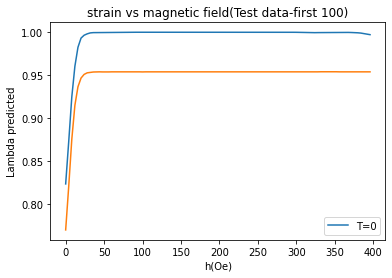

In [117]:
plt.plot(h_test_in_5000[0:100]/79.77,prediction_5000[0][0:100].detach().numpy())
plt.plot(h_test_in_5000[0:100]/79.77,(strain_tensor_5000[0:100]))
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted")
plt.legend(['T=0'])
plt.title('strain vs magnetic field(Test data-first 100)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot for uniform samples and fixed T 

In [118]:
predicted_uni=min_max_scaler_strain_5000.inverse_transform(prediction_5000[0].detach().numpy())*10**6
actual_uni=min_max_scaler_strain_5000.inverse_transform(strain_tensor_5000)*10**6

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 360x360 with 0 Axes>

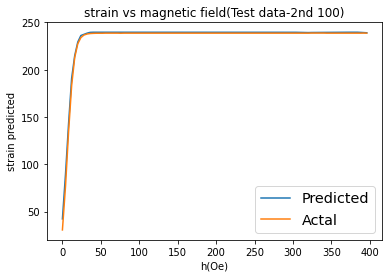

In [119]:
# plt.plot(h_test_in_5000[0:100]/79.77,predicted_uni[0:100])
# plt.plot(h_test_in_5000[0:100]/79.77,actual_uni[0:100])

plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.plot(h_test_in_5000[0:100]/79.77,predicted_uni[100:200]+17,label='Predicted')
plt.plot(h_test_in_5000[0:100]/79.77,actual_uni[100:200],label='Actal')
plt.xlabel("h(Oe)")
plt.ylabel("strain predicted")
plt.legend(['T=96000'])
legend = ax.legend(loc='best', fontsize='x-large')
plt.title('strain vs magnetic field(Test data-2nd 100)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot for uniform samples and fixed T

<function matplotlib.pyplot.show(close=None, block=None)>

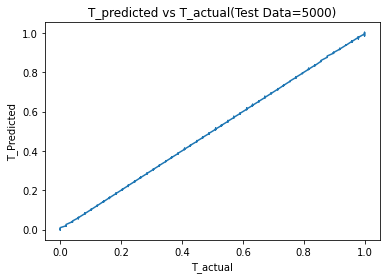

In [120]:
plt.plot(T_tensor_5000,prediction_5000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test Data=5000)')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for uniform input sampling

<function matplotlib.pyplot.show(close=None, block=None)>

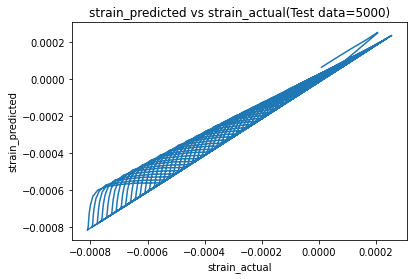

In [127]:
plt.plot(min_max_scaler_strain.inverse_transform(strain_tensor_5000),min_max_scaler_strain.inverse_transform(prediction_5000[0].detach().numpy()))
plt.xlabel("strain_actual")
plt.ylabel("strain_predicted")
plt.title('strain_predicted vs strain_actual(Test data=5000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for uniform samples 